<a href="https://colab.research.google.com/github/weso500/IOT-Anomaly-Detection/blob/main/Single_Image_VAE_Working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Obtained intially from https://keras.io/examples/generative/vae/ and https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/generative/ipynb/vae.ipynb

In [1]:
pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.


In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

In [3]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

Use this notebook as example for obtaining images: https://colab.research.google.com/drive/1EOFDisibXb9a4A3lZ_2z4Jbhlnx0OVy6 The below takes care of obtaining images

In [4]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 14, 14, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 7, 7, 64)       │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 3136)           │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │         50,192 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,652 (272.08 KB)

 Trainable params: 69,652 (272.08 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,667 (256.51 KB)

 Trainable params: 65,667 (256.51 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):  # Add the call method
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [7]:
!unzip /content/Compiled_Data.zip

Streaming output truncated to the last 5000 lines.
  inflating: Compiled_Data/Normal/Spectrograms_Normal_A+_IGBT-I/342Normal.png  
  inflating: Compiled_Data/Normal/Spectrograms_Normal_A+_IGBT-I/326Normal.png  
  inflating: Compiled_Data/Normal/Spectrograms_Normal_MOD-V/194Normal.png  
  inflating: Compiled_Data/Normal/Spectrograms_Normal_A+_IGBT-I/348Normal.png  
  inflating: Compiled_Data/Normal/Spectrograms_Normal_MOD-V/187Normal.png  
  inflating: Compiled_Data/Normal/Spectrograms_Normal_A+_IGBT-I/324Normal.png  
  inflating: Compiled_Data/Normal/Spectrograms_Normal_MOD-V/198Normal.png  
  inflating: Compiled_Data/Normal/Spectrograms_Normal_A+_IGBT-I/325Normal.png  
  inflating: Compiled_Data/Normal/Spectrograms_Normal_MOD-V/193Normal.png  
  inflating: Compiled_Data/Normal/Spectrograms_Normal_MOD-V/186Normal.png  
  inflating: Compiled_Data/Normal/Spectrograms_Normal_MOD-V/202Normal.png  
  inflating: Compiled_Data/Normal/Spectrograms_Normal_A+_IGBT-I/320Normal.png  
  inflating: 

In [8]:
Sample = '/content/Compiled_Data/Normal/Spectrograms_Normal_B-FLUX'

In [36]:
Anomaly = '/content/Compiled_Data/Anomaly/Spectrograms_Anomaly_B-FLUX'

In [9]:
import os

# Print the contents of the directory
print(os.listdir(Sample))

# Check if the directory contains any image files
image_extensions = ('.bmp', '.gif', '.jpeg', '.jpg', '.png')
image_files = [f for f in os.listdir(Sample) if f.endswith(image_extensions)]
print("Image files found:", image_files)

['496Normal.png', '426Normal.png', '393Normal.png', '53Normal.png', '568Normal.png', '425Normal.png', '371Normal.png', '621Normal.png', '8Normal.png', '271Normal.png', '545Normal.png', '594Normal.png', '151Normal.png', '319Normal.png', '622Normal.png', '588Normal.png', '246Normal.png', '333Normal.png', '580Normal.png', '561Normal.png', '352Normal.png', '72Normal.png', '247Normal.png', '98Normal.png', '657Normal.png', '530Normal.png', '208Normal.png', '210Normal.png', '248Normal.png', '440Normal.png', '287Normal.png', '23Normal.png', '631Normal.png', '21Normal.png', '516Normal.png', '268Normal.png', '30Normal.png', '299Normal.png', '462Normal.png', '491Normal.png', '197Normal.png', '265Normal.png', '279Normal.png', '514Normal.png', '360Normal.png', '638Normal.png', '84Normal.png', '36Normal.png', '294Normal.png', '482Normal.png', '18Normal.png', '610Normal.png', '487Normal.png', '139Normal.png', '226Normal.png', '567Normal.png', '282Normal.png', '215Normal.png', '258Normal.png', '666Nor

In [37]:
import os

# Print the contents of the directory
print(os.listdir(Anomaly))

# Check if the directory contains any image files
image_extensions = ('.bmp', '.gif', '.jpeg', '.jpg', '.png')
image_files = [f for f in os.listdir(Anomaly) if f.endswith(image_extensions)]
print("Image files found:", image_files)

['180Anomaly.png', '76Anomaly.png', '136Anomaly.png', '139Anomaly.png', '75Anomaly.png', '143Anomaly.png', '25Anomaly.png', '73Anomaly.png', '146Anomaly.png', '44Anomaly.png', '123Anomaly.png', '60Anomaly.png', '105Anomaly.png', '12Anomaly.png', '112Anomaly.png', '172Anomaly.png', '163Anomaly.png', '179Anomaly.png', '111Anomaly.png', '78Anomaly.png', '134Anomaly.png', '114Anomaly.png', '16Anomaly.png', '53Anomaly.png', '15Anomaly.png', '118Anomaly.png', '107Anomaly.png', '165Anomaly.png', '10Anomaly.png', '178Anomaly.png', '141Anomaly.png', '88Anomaly.png', '41Anomaly.png', '34Anomaly.png', '81Anomaly.png', '35Anomaly.png', '126Anomaly.png', '140Anomaly.png', '28Anomaly.png', '150Anomaly.png', '145Anomaly.png', '57Anomaly.png', '157Anomaly.png', '3Anomaly.png', '100Anomaly.png', '125Anomaly.png', '124Anomaly.png', '106Anomaly.png', '89Anomaly.png', '121Anomaly.png', '138Anomaly.png', '96Anomaly.png', '69Anomaly.png', '176Anomaly.png', '2Anomaly.png', '71Anomaly.png', '56Anomaly.png', '

In [10]:
input = keras.utils.image_dataset_from_directory(
    directory = Sample, labels = None, image_size = (28,28))
rescale = tf.keras.layers.Rescaling(1./255)
input = input.map(rescale)

Found 690 files.


In [38]:
Anomaly = keras.utils.image_dataset_from_directory(
    directory = Anomaly, labels = None, image_size = (28,28))
rescale = tf.keras.layers.Rescaling(1./255)
input = input.map(rescale)

Found 182 files.


In [11]:
#(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
#mnist_digits = np.concatenate([x_train, x_test], axis=0)
#mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(input, epochs=30, batch_size=130)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - kl_loss: 0.4854 - loss: 522.1642 - reconstruction_loss: 521.6788
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - kl_loss: 1.2952 - loss: 370.4691 - reconstruction_loss: 369.1740
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - kl_loss: 1.7898 - loss: 314.7293 - reconstruction_loss: 312.9395
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - kl_loss: 4.8833 - loss: 274.0023 - reconstruction_loss: 269.1190
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - kl_loss: 3.4861 - loss: 244.5823 - reconstruction_loss: 241.0962
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - kl_loss: 2.7303 - loss: 229.1877 - reconstruction_loss: 226.4574
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - kl_loss: 2.3355 - loss: 217.0670 - reconstruction_loss: 214.7316
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - kl_loss: 2.0519 - loss: 207.6629 - reconstruction_loss: 205.6110
Epoch 9/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - k

In [23]:
pip install sewar

  Preparing metadata (setup.py) ... done
  Created wheel for sewar: filename=sewar-0.4.6-py3-none-any.whl size=11419 sha256=c4da86634f576852f2d503ef6d30724b57c593a04fd0554f05af8ff87de58980
  Stored in directory: /root/.cache/pip/wheels/3f/af/02/9c6556ba287b62a945d737def09b8b8c35c9e1d82b9dfae84c
Successfully built sewar


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━

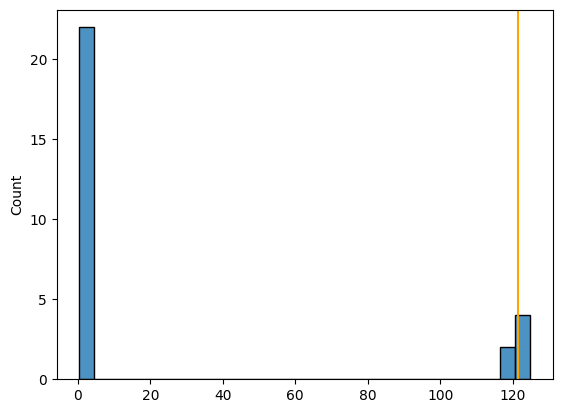

In [42]:
from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

mse_values = [] # Create an empty list to store mse values

for elem in input.take(600):
  elem_np = elem.numpy()
  exp = vae.predict(elem)
  exp_np = tf.get_static_value(exp)
  x = rmse(elem_np, exp_np)
  mse_values.append(x) # Append each mse value to the list

for elem in Anomaly.take(180):
  elem_np = elem.numpy()
  exp = vae.predict(elem)
  exp_np = tf.get_static_value(exp)
  x = rmse(elem_np, exp_np)
  mse_values.append(x) # Append each mse value to the list

loss_threshold = np.percentile(mse_values, 95) # Calculate the threshold on the list of mse values
print(f'The prediction loss threshold for 2% of outliers is {loss_threshold:.2f}')

# Visualize the threshold using the list of mse values
sns.histplot(mse_values, bins=30, alpha=0.8)
plt.axvline(x=loss_threshold, color='orange')